# Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning

### Presented by Zabdy LEOS 
### June 20, 2025

In machine learning tasks, deep neural networks are powerful models, however they do not capture uncertainty in their predictions making their use critical in sensitive applications. The paper by Gal and Ghahramani (2016) proposes to interpret the use of dropout as a form of approximate Bayesian inference in deep Gaussian processes. This reinterpretation allows estimating model uncertainty without modifying the architecture or significantly increasing the computational cost, simply by reusing the dropout mechanism during inference (MC Dropout).

# Glossary

**I. Imports**  

**II. Theoretical Foundations**  

**III. Mathematical Verifications**  

**IV. Regression Experiments: Predictive Uncertainty with Dropout**  

1. **Standard dropout with weight averaging:** 
2. **MC dropout with ReLU activations:** 
3. **MC dropout with Tanh activations:** 
4. **Plots together:** 

**V. Model Uncertainty for Classification Tasks**

**VI. Comparation with Standard Dropout**

## I. Imports

In [1]:
## Imports
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import functional as TF
import torch.nn.functional as F
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## II. Theoretical Foundations

In this section I will be implementing some propabilistic concepts that are from the paper. There are some core concepts that were revised in class susch as ELBO, Monte Carlo, the use of likelihood, KL divergence, uncertainty and Bayes. 

In [2]:
## Equation 1: Loss function with dropout

base_loss_fn = nn.MSELoss()  # o nn.CrossEntropyLoss() for classification tasks

def dropout_loss(y_pred, y_true, model, lambda_reg=1e-4):
    """
    total loss with L2 regularization (weight decay).
    """
    loss = base_loss_fn(y_pred, y_true)
    l2_norm = sum(torch.norm(param)**2 for name, param in model.named_parameters() if 'weight' in name or 'bias' in name)
    return loss + lambda_reg * l2_norm

In [3]:
## Equation 2: Bayessian prediction (Deep GP)

def mc_dropout_predict(model, x, T=100):
    """
    Performs T forward passes with dropout enabled and averages the results.
    """
    model.train()  # Importante: mantenemos dropout activado
    preds = torch.stack([model(x) for _ in range(T)])
    pred_mean = preds.mean(dim=0)
    return pred_mean, preds

In [4]:
## Equation 3: Evidence Lower Bound 

def elbo_loss(y_true, y_samples, model, dropout_ps, l=1.0, tau=1.0):
    """
    Implements ELBO: MC likelihood + KL approx (regularization).
    
    y_samples: [T, batch_size, D]
    model: network with attributes .parameters() or .named_parameters()
    dropout_ps: list with p_i per layer
    l: length-scale
    tau: model accuracy (1 / variance)
    """
    # Montecarlo likelihood 
    log_likelihood = gaussian_log_likelihood(y_true, y_samples, tau)
    likelihood_term = -log_likelihood.mean()

    #  KL regularization term
    kl_term = 0.0
    for i, (name, param) in enumerate(model.named_parameters()):
        if 'weight' in name or 'bias' in name:
            pi = dropout_ps[i]  # Probability 
            scale = (pi * l**2) / (2 * tau)
            kl_term += scale * torch.norm(param)**2

    return likelihood_term + kl_term

In [5]:
## Equation 4: LGP-MC (Laplace with Monte Carlo)

def elbo_loss_gp_mc(y_true, y_samples, model, dropout_ps, l=1.0, tau=1.0):
    """
    Calculates the GP-MC objective function (equation 4).
    
    y_samples: tensor [T, batch_size, D]
    model: network with .named_parameters()
    dropout_ps: list with p_i per layer
    l: length-scale
    tau: model precision (1 / noise variance)
    """
    N = y_true.shape[0]  # tamaño del batch

    # 1. Likelihood estimated using Monte Carlo
    log_likelihood = gaussian_log_likelihood(y_true, y_samples, tau)
    likelihood_term = -log_likelihood.mean() / tau  # equation division

    # 2. KL approximation with L2
    kl_term = 0.0
    i = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            pi = dropout_ps[i]
            kl_term += (pi * l**2) / (2 * tau * N) * torch.norm(param)**2
        elif 'bias' in name:
            kl_term += (l**2) / (2 * tau * N) * torch.norm(param)**2
            i += 1  # weight goes with bias

    # Total loss
    return likelihood_term + kl_term


In [6]:
## Equation 5: Approximate predictive distribution

def mc_dropout_samples(model, x, T=100):
    """
    Obtains T model output samples using MC Dropout.

    model: neural network with dropout layers
    x: input [batch, input_dim]
    T: number of forward passes

    return: tensor [T, batch, output_dim]
    """
    model.train()  # Dropout activado
    return torch.stack([model(x) for _ in range(T)], dim=0)

In [7]:
## Equation 6: Approximate predictive mean

def mc_predictive_mean(y_samples):
    """
    Calculates the predictive mean E[y* | x*] from the MC samples.

    y_samples: tensor [T, batch, output_dim]
    return: tensor [batch, output_dim]
    """
    return y_samples.mean(dim=0)

In [8]:
## Equation 7: Approximate predictive variance (with uncertainty)

def mc_predictive_variance(y_samples, tau=1.0):
    """
    Computes the total predictive variance from MC Dropout samples.

    Parameters:
        y_samples: tensor of shape [T, batch_size, output_dim]
                   T stochastic forward passes through the model
        tau: model precision (1 / observation noise variance)

    Returns:
        predictive_variance: tensor [batch_size, output_dim]
    """
    # Predictive mean
    y_mean = y_samples.mean(dim=0)  # [batch, D]

    # Second raw moment (E[y^T y]) — elementwise squared mean
    second_moment = (y_samples ** 2).mean(dim=0)  # [batch, D]

    # Variance: E[y^2] - (E[y])^2 + tau^{-1}
    predictive_variance = second_moment - y_mean**2 + 1.0 / tau

    return predictive_variance

In [9]:
## Equation 8: Predictive log-likelihood for regression

def predictive_log_likelihood(y_true, y_samples, tau=1.0):
    """
    Computes the predictive log-likelihood for regression (Eq. 8).
    
    Parameters:
        y_true: tensor [batch_size, output_dim]
        y_samples: tensor [T, batch_size, output_dim]
        tau: model precision (1 / observation noise variance)
    
    Returns:
        log_likelihood: tensor [batch_size]
    """
    T = y_samples.shape[0]
    D = y_true.shape[1]  # output dimensionality
    
    # Compute squared error for each sample
    squared_error = ((y_samples - y_true.unsqueeze(0)) ** 2).sum(dim=-1)  # [T, batch]
    
    # Logsumexp over T samples
    logsumexp_term = torch.logsumexp(-0.5 * tau * squared_error, dim=0)  # [batch]
    
    # Normalization constants
    const = -math.log(T) - 0.5 * D * math.log(2 * math.pi) + 0.5 * math.log(tau)
    
    return logsumexp_term + const

In [10]:
## Equation to calculate the precsion value of the model (pi)

def estimate_tau(p: float, l: float, N: int, lambda_reg: float) -> float:
    """
    Estimate model precision tau from dropout probability, prior length-scale, dataset size, and weight decay.
    
    Parameters:
        p: dropout keep probability (e.g., 0.8 if Dropout(p=0.2))
        l: prior length-scale
        N: number of training samples
        lambda_reg: weight decay (L2 regularization coefficient)
    
    Returns:
        tau: model precision
    """
    return (p * l**2) / (2 * N * lambda_reg)

## III. Mathematical verifications

In [11]:
def verify_equation_1(model, x, y_true, lambda_reg=1e-4):
    """
    Verifies that the dropout_loss function returns the same result as the base_loss_fn + L2 term.
    """
    model.train()  # Activate dropout
    y_pred = model(x)
    loss = dropout_loss(y_pred, y_true, model, lambda_reg)
    base_loss = base_loss_fn(y_pred, y_true)
    expected_loss = base_loss + lambda_reg * sum(
        torch.norm(param)**2 for name, param in model.named_parameters() if 'weight' in name or 'bias' in name
    )
    
    print(f"Dropout loss: {loss.item():.6f}")
    print(f"Expected loss: {expected_loss.item():.6f}")
    print(f"Base loss: {base_loss.item():.6f}")
    
    return torch.isclose(loss, expected_loss, atol=1e-5)

# Print the result of the verification
def verify_equation_1_example():
    # Example model
    model = nn.Sequential(
        nn.Linear(10, 20),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(20, 1)
    )
    
    # Example data
    x = torch.randn(5, 10)  # batch size 5, input dim 10
    y_true = torch.randn(5, 1)  # batch size 5, output dim 1
    
    # Verify equation 1
    result = verify_equation_1(model, x, y_true)
    print(f"Equation 1 holds: {result.item()}") 

## IV. Regression Experiments: Predictive Uncertainty with Dropout

In this section I implement and compare 3 of the regression experiments, following the setup in Gal & Ghahramani (2016), to analyze how different neural network configurations express predictive uncertainty on the Mauna Loa CO₂ dataset. 

Two of these experiments use Monte Carlo Dropout, the other use standard dropout inference.

The four experiments presented in the paper are:

1. **Standard dropout with weight averaging** (no MC sampling, dropout disabled at test time)
2. **Gaussian Process** with SE kernel (external reference)
3. **MC dropout with ReLU activations**
4. **MC dropout with Tanh activations**

These experiments illustrate how different models behave when extrapolating beyond the training domain, and how uncertainty is expressed in each case.

## 1. Standard dropout with weight averaging (no MC sampling, dropout disabled at test time)

In [12]:
df_mauna_loa = pd.read_csv(
    "co2_mm_mlo.txt",
    sep=r"\s+",
    comment='#',
    header=None,
    names=["year", "month", "decimal_date", "average", "deseasonalized", "days", "stdev", "uncertainty"]
)

# Data tuning
df_mauna_loa = df_mauna_loa.sort_values(by=["year", "month"]).reset_index(drop=True)

co2_values = df_mauna_loa["deseasonalized"]
co2_values = co2_values[co2_values != -99.99].reset_index(drop=True)
co2_subset = co2_values[:200]

# Normalizing + tensor conversion
y = torch.tensor(co2_subset.values, dtype=torch.float32).unsqueeze(1)
y_min, y_max = y.min(), y.max()
y_norm = (y - y_min) / (y_max - y_min)

# Temporal axis for plotting
x = torch.linspace(0, 1, steps=len(y_norm)).unsqueeze(1)

In [13]:
## Standart dropout, no MC

# defining the model
class StandardDropoutRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.net(x)

model_std = StandardDropoutRegressor()
optimizer = torch.optim.Adam(model_std.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
lambda_reg = 1e-4

def dropout_loss(y_pred, y_true, model, lambda_reg):
    mse = loss_fn(y_pred, y_true)
    l2 = sum(torch.norm(p)**2 for name, p in model.named_parameters() if 'weight' in name or 'bias' in name)
    return mse + lambda_reg * l2

# Training 
n_epochs = 1000
for epoch in range(n_epochs):
    model_std.train()  # Activar dropout durante entrenamiento
    optimizer.zero_grad()
    y_pred = model_std(x)
    loss = dropout_loss(y_pred, y_norm, model_std, lambda_reg)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"[Standard Dropout] Epoch {epoch} - Loss: {loss.item():.4f}")

[Standard Dropout] Epoch 0 - Loss: 0.5614
[Standard Dropout] Epoch 100 - Loss: 0.0130
[Standard Dropout] Epoch 200 - Loss: 0.0102
[Standard Dropout] Epoch 300 - Loss: 0.0089
[Standard Dropout] Epoch 400 - Loss: 0.0090
[Standard Dropout] Epoch 500 - Loss: 0.0076
[Standard Dropout] Epoch 600 - Loss: 0.0072
[Standard Dropout] Epoch 700 - Loss: 0.0071
[Standard Dropout] Epoch 800 - Loss: 0.0064
[Standard Dropout] Epoch 900 - Loss: 0.0064


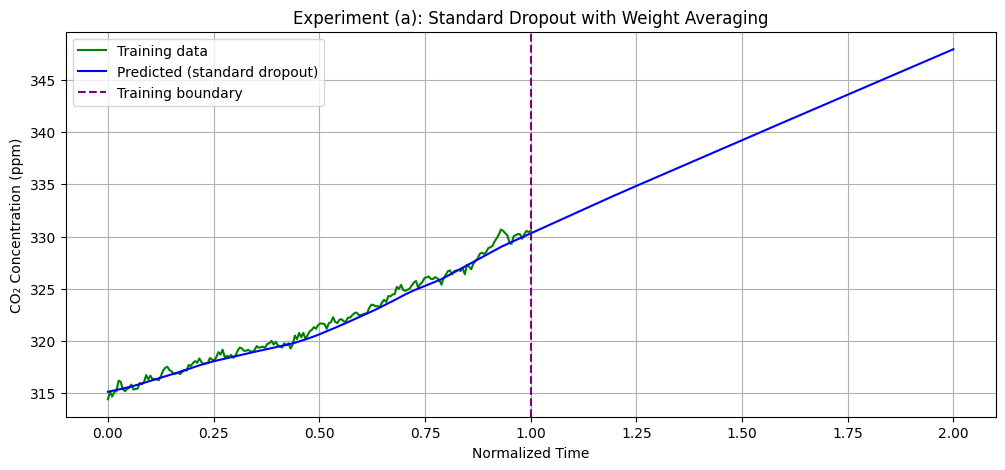

In [14]:
## Prediction without MC Dropout

x_extended = torch.linspace(0, 2.0, steps=400).unsqueeze(1)

model_std.eval()
with torch.no_grad():
    y_pred_std = model_std(x_extended)

y_pred_std_denorm = y_pred_std * (y_max - y_min) + y_min
y_true_denorm = y_norm * (y_max - y_min) + y_min  # ← esta línea estaba incompleta

# Plot
plt.figure(figsize=(12, 5))
plt.plot(x.numpy(), y_true_denorm.numpy(), 'g-', label="Training data")
plt.plot(x_extended.numpy(), y_pred_std_denorm.numpy(), 'b-', label="Predicted (standard dropout)")
plt.axvline(x=1.0, color='purple', linestyle='--', label="Training boundary")
plt.title("Experiment (a): Standard Dropout with Weight Averaging")
plt.xlabel("Normalized Time")
plt.ylabel("CO₂ Concentration (ppm)")
plt.grid(True)
plt.legend()
plt.show()

## 2. MC dropout with ReLU activations

In [15]:
## Using Mauna Loa CO2 dataset for testing

df_mauna_loa = pd.read_csv(
    "co2_mm_mlo.txt",
    sep=r"\s+",
    comment='#',
    header=None,
    names=["year", "month", "decimal_date", "average", "deseasonalized", "days", "stdev", "uncertainty"]
)

print(df_mauna_loa.head(10))
print(df_mauna_loa[["decimal_date", "deseasonalized"]].head(10))

   year  month  decimal_date  average  deseasonalized  days  stdev  \
0  1958      3     1958.2027   315.71          314.44    -1  -9.99   
1  1958      4     1958.2877   317.45          315.16    -1  -9.99   
2  1958      5     1958.3699   317.51          314.69    -1  -9.99   
3  1958      6     1958.4548   317.27          315.15    -1  -9.99   
4  1958      7     1958.5370   315.87          315.20    -1  -9.99   
5  1958      8     1958.6219   314.93          316.21    -1  -9.99   
6  1958      9     1958.7068   313.21          316.11    -1  -9.99   
7  1958     10     1958.7890   312.42          315.41    -1  -9.99   
8  1958     11     1958.8740   313.33          315.21    -1  -9.99   
9  1958     12     1958.9562   314.67          315.43    -1  -9.99   

   uncertainty  
0        -0.99  
1        -0.99  
2        -0.99  
3        -0.99  
4        -0.99  
5        -0.99  
6        -0.99  
7        -0.99  
8        -0.99  
9        -0.99  
   decimal_date  deseasonalized
0     1958

Epoch 0 - Loss: 0.2138
Epoch 100 - Loss: 0.0124
Epoch 200 - Loss: 0.0100
Epoch 300 - Loss: 0.0079
Epoch 400 - Loss: 0.0077
Epoch 500 - Loss: 0.0069
Epoch 600 - Loss: 0.0067
Epoch 700 - Loss: 0.0063
Epoch 800 - Loss: 0.0060
Epoch 900 - Loss: 0.0058


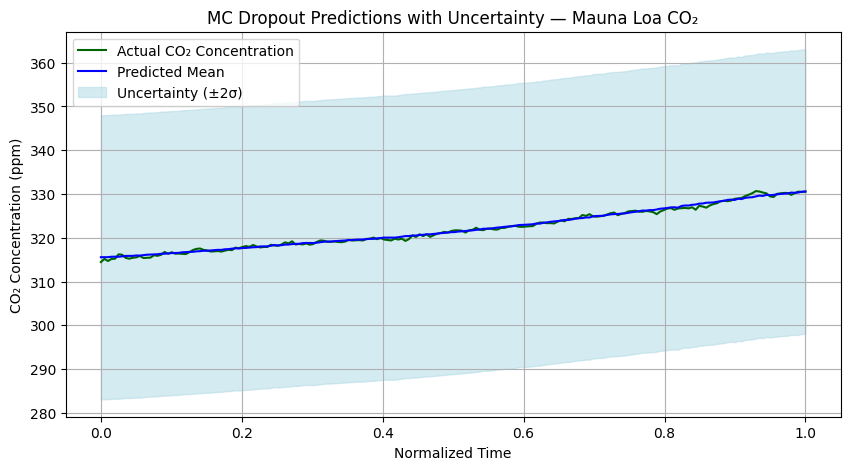

In [16]:
# Define model
class MCDropoutRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MCDropoutRegressor()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
base_loss_fn = nn.MSELoss()
lambda_reg = 1e-4

# Regulariztion loss with L2
def dropout_loss(y_pred, y_true, model, lambda_reg):
    mse = base_loss_fn(y_pred, y_true)
    l2 = sum(torch.norm(p)**2 for name, p in model.named_parameters() if 'weight' in name or 'bias' in name)
    return mse + lambda_reg * l2

# Training
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()  # Mantener Dropout activo
    optimizer.zero_grad()
    y_pred = model(x)
    loss = dropout_loss(y_pred, y_norm, model, lambda_reg)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

def mc_dropout_samples(model, x_input, T=100):
    model.train()
    return torch.stack([model(x_input).detach() for _ in range(T)], dim=0)

def mc_predictive_mean(y_samples):
    return y_samples.mean(dim=0)

def mc_predictive_variance(y_samples, tau=1.0):
    y_mean = y_samples.mean(dim=0)
    second_moment = (y_samples ** 2).mean(dim=0)
    return second_moment - y_mean**2 + 1.0 / tau

# Prediction
T = 100
y_samples = mc_dropout_samples(model, x, T)
y_mean = mc_predictive_mean(y_samples)
y_std = mc_predictive_variance(y_samples)

# Un-normalizing the predictions to get real results
y_mean_denorm = y_mean * (y_max - y_min) + y_min
y_std_denorm = y_std.sqrt() * (y_max - y_min)
y_true_denorm = y_norm * (y_max - y_min) + y_min

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x.numpy(), y_true_denorm.numpy(), label="Actual CO₂ Concentration", color='darkgreen')
plt.plot(x.numpy(), y_mean_denorm.detach().numpy(), label="Predicted Mean", color='blue')
plt.fill_between(x.numpy().flatten(), 
                 (y_mean_denorm - 2 * y_std_denorm).detach().numpy().flatten(),
                 (y_mean_denorm + 2 * y_std_denorm).detach().numpy().flatten(),
                 color='lightblue', alpha=0.5, label="Uncertainty (±2σ)")
plt.xlabel("Normalized Time")
plt.ylabel("CO₂ Concentration (ppm)")
plt.title("MC Dropout Predictions with Uncertainty — Mauna Loa CO₂")
plt.legend()
plt.grid(True)
plt.show()

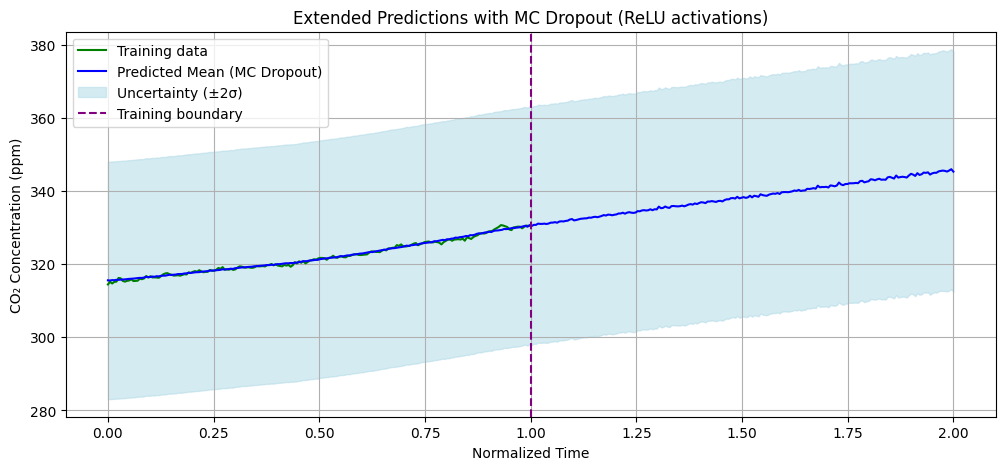

In [17]:
# Extenden prediction with MC Dropout (ReLU activations)
x_extended = torch.linspace(0, 2.0, steps=400).unsqueeze(1)
T = 100
y_samples_relu = mc_dropout_samples(model, x_extended, T)
y_mean_relu = mc_predictive_mean(y_samples_relu)
y_std_relu = mc_predictive_variance(y_samples_relu)

# Denormalize
y_mean_relu_denorm = y_mean_relu * (y_max - y_min) + y_min
y_std_relu_denorm = y_std_relu.sqrt() * (y_max - y_min)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(x.numpy(), y_true_denorm.numpy(), 'g-', label="Training data")
plt.plot(x_extended.numpy(), y_mean_relu_denorm.detach().numpy(), 'b-', label="Predicted Mean (MC Dropout)")
plt.fill_between(x_extended.numpy().flatten(),
                 (y_mean_relu_denorm - 2 * y_std_relu_denorm).detach().numpy().flatten(),
                 (y_mean_relu_denorm + 2 * y_std_relu_denorm).detach().numpy().flatten(),
                 color='lightblue', alpha=0.5, label="Uncertainty (±2σ)")
plt.axvline(x=1.0, color='purple', linestyle='--', label="Training boundary")
plt.title("Extended Predictions with MC Dropout (ReLU activations)")
plt.xlabel("Normalized Time")
plt.ylabel("CO₂ Concentration (ppm)")
plt.grid(True)
plt.legend()
plt.show()  

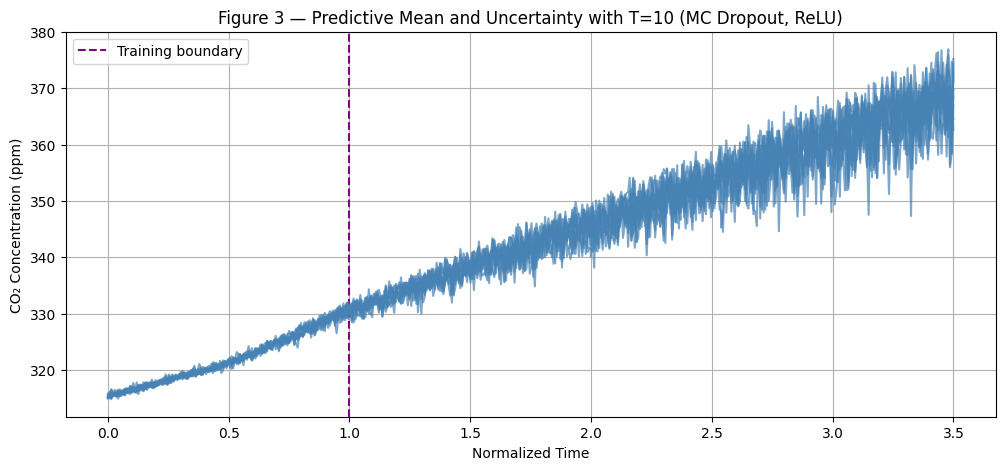

In [ ]:
## MC Dropout with Relu but only 10 samples
# This is used to show MC Dropout works even with a few samples

x_extended = torch.linspace(0, 3.5, steps=500).unsqueeze(1)  # Más allá de x = 2
T_small = 10

# 10 prediction without mean 
model.train()
y_samples_small = torch.stack([model(x_extended).detach() for _ in range(T_small)], dim=0)  # [10, N, 1]

# Denormalize 
y_samples_small_denorm = y_samples_small * (y_max - y_min) + y_min  # [10, N, 1]

plt.figure(figsize=(12, 5))
plt.axvline(x=1.0, color='purple', linestyle='--', label="Training boundary")

# MC curves
for i in range(T_small):
    plt.plot(x_extended.squeeze().numpy(),
             y_samples_small_denorm[i].squeeze().numpy(),
             color='steelblue', alpha=0.7)

plt.title("Predictive Mean and Uncertainty with T=10 (MC Dropout, ReLU)")
plt.xlabel("Normalized Time")
plt.ylabel("CO₂ Concentration (ppm)")
plt.grid(True)
plt.legend()
plt.show()


## 4. MC dropout with Tanh activations

In [19]:
## Defining the model
class MCDropoutTanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 100),
            nn.Tanh(),
            nn.Dropout(p=0.1),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Dropout(p=0.1),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.net(x)

In [20]:
## Training the model

model_tanh = MCDropoutTanh()
optimizer = torch.optim.Adam(model_tanh.parameters(), lr=1e-3)
lambda_reg = 1e-4
loss_fn = nn.MSELoss()

def dropout_loss(y_pred, y_true, model, lambda_reg):
    mse = loss_fn(y_pred, y_true)
    l2 = sum(torch.norm(p)**2 for name, p in model.named_parameters() if 'weight' in name or 'bias' in name)
    return mse + lambda_reg * l2

# Training
n_epochs = 1000
for epoch in range(n_epochs):
    model_tanh.train()
    optimizer.zero_grad()
    y_pred = model_tanh(x)
    loss = dropout_loss(y_pred, y_norm, model_tanh, lambda_reg)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"[Tanh MC Dropout] Epoch {epoch} - Loss: {loss.item():.4f}") 

[Tanh MC Dropout] Epoch 0 - Loss: 0.2548
[Tanh MC Dropout] Epoch 100 - Loss: 0.0146
[Tanh MC Dropout] Epoch 200 - Loss: 0.0130
[Tanh MC Dropout] Epoch 300 - Loss: 0.0120
[Tanh MC Dropout] Epoch 400 - Loss: 0.0116
[Tanh MC Dropout] Epoch 500 - Loss: 0.0109
[Tanh MC Dropout] Epoch 600 - Loss: 0.0104
[Tanh MC Dropout] Epoch 700 - Loss: 0.0096
[Tanh MC Dropout] Epoch 800 - Loss: 0.0093
[Tanh MC Dropout] Epoch 900 - Loss: 0.0086


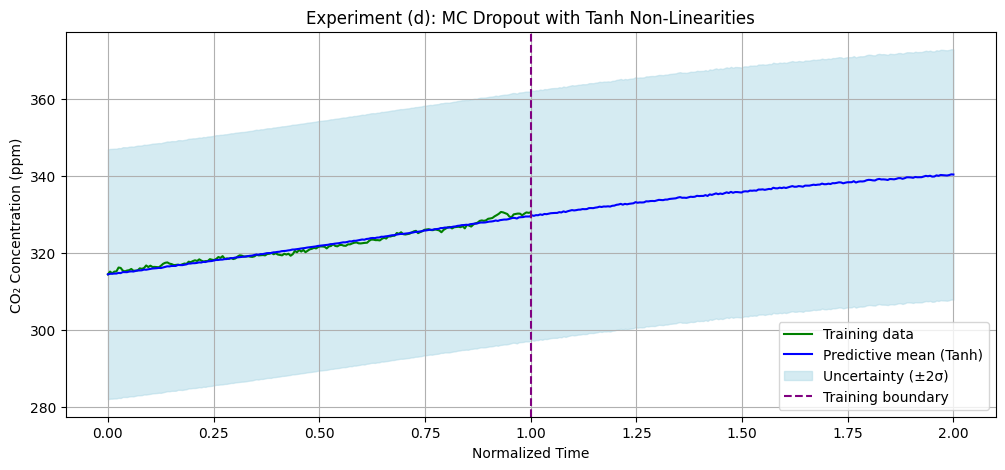

In [21]:
## Prediction with MC Dropout

def mc_dropout_samples(model, x_input, T=100):
    model.train()
    return torch.stack([model(x_input).detach() for _ in range(T)], dim=0)

def mc_predictive_mean(y_samples):
    return y_samples.mean(dim=0)

def mc_predictive_variance(y_samples, tau=1.0):
    y_mean = y_samples.mean(dim=0)
    second_moment = (y_samples ** 2).mean(dim=0)
    return second_moment - y_mean**2 + 1.0 / tau

# Extrapolation
x_extended = torch.linspace(0, 2.0, steps=400).unsqueeze(1)
T = 100
y_samples_tanh = mc_dropout_samples(model_tanh, x_extended, T)
y_mean_tanh = mc_predictive_mean(y_samples_tanh)
y_std_tanh = mc_predictive_variance(y_samples_tanh)

# Denormalization
y_mean_tanh_denorm = y_mean_tanh * (y_max - y_min) + y_min
y_std_tanh_denorm = y_std_tanh.sqrt() * (y_max - y_min)
y_true_denorm = y_norm * (y_max - y_min) + y_min

# Plot
plt.figure(figsize=(12, 5))
plt.plot(x.numpy(), y_true_denorm.numpy(), 'g-', label="Training data")
plt.plot(x_extended.numpy(), y_mean_tanh_denorm.numpy(), 'b-', label="Predictive mean (Tanh)")
plt.fill_between(x_extended.squeeze().numpy(),
                 (y_mean_tanh_denorm - 2 * y_std_tanh_denorm).squeeze().numpy(),
                 (y_mean_tanh_denorm + 2 * y_std_tanh_denorm).squeeze().numpy(),
                 color='lightblue', alpha=0.5, label="Uncertainty (±2σ)")
plt.axvline(x=1.0, color='purple', linestyle='--', label="Training boundary")
plt.xlabel("Normalized Time")
plt.ylabel("CO₂ Concentration (ppm)")
plt.title("Experiment (d): MC Dropout with Tanh Non-Linearities")
plt.grid(True)
plt.legend()
plt.show()

## 4. Plots together

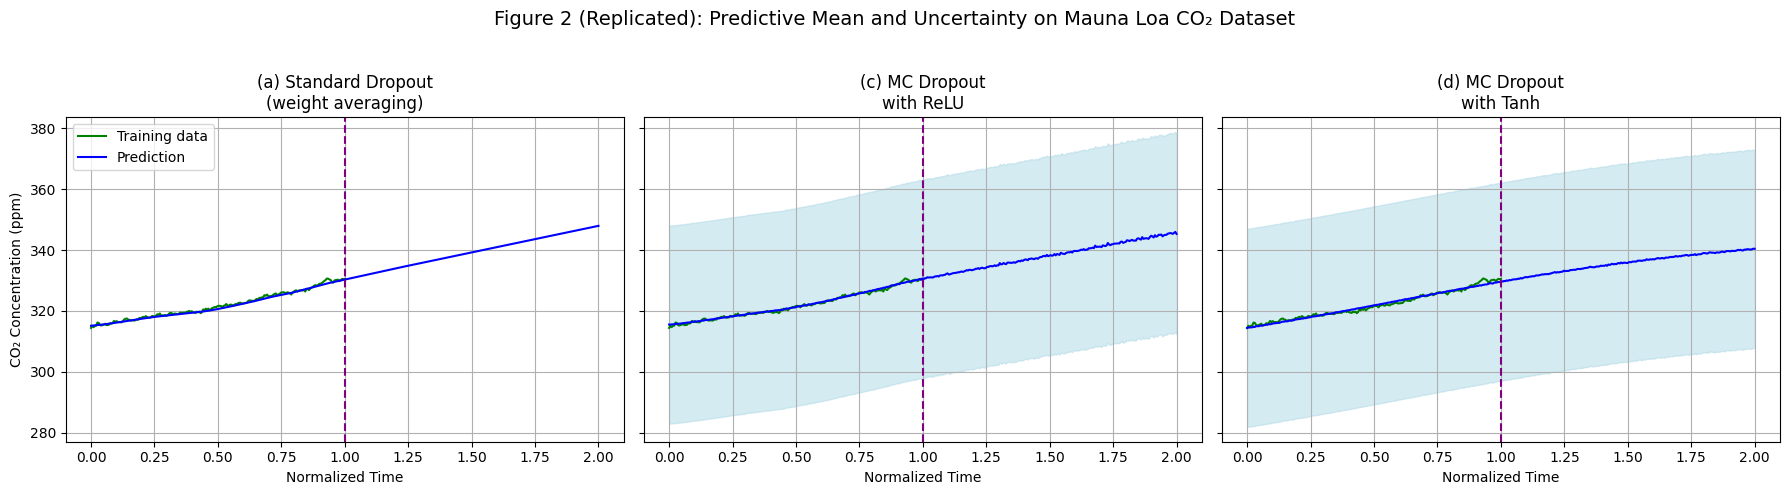

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# --- (a) Standard Dropout ---
axs[0].plot(x.numpy(), y_true_denorm.numpy(), 'g-', label="Training data")
axs[0].plot(x_extended.numpy(), y_pred_std_denorm.numpy(), 'b-', label="Prediction")
axs[0].axvline(x=1.0, color='purple', linestyle='--')
axs[0].set_title("(a) Standard Dropout\n(weight averaging)")
axs[0].set_xlabel("Normalized Time")
axs[0].set_ylabel("CO₂ Concentration (ppm)")
axs[0].grid(True)

# --- (c) MC Dropout with ReLU ---
axs[1].plot(x.numpy(), y_true_denorm.numpy(), 'g-')
axs[1].plot(x_extended.numpy(), y_mean_relu_denorm.numpy(), 'b-')
axs[1].fill_between(x_extended.squeeze().numpy(),
                    (y_mean_relu_denorm - 2 * y_std_relu_denorm).squeeze().numpy(),
                    (y_mean_relu_denorm + 2 * y_std_relu_denorm).squeeze().numpy(),
                    color='lightblue', alpha=0.5)
axs[1].axvline(x=1.0, color='purple', linestyle='--')
axs[1].set_title("(c) MC Dropout\nwith ReLU")
axs[1].set_xlabel("Normalized Time")
axs[1].grid(True)

# --- (d) MC Dropout with Tanh ---
axs[2].plot(x.numpy(), y_true_denorm.numpy(), 'g-')
axs[2].plot(x_extended.numpy(), y_mean_tanh_denorm.numpy(), 'b-')
axs[2].fill_between(x_extended.squeeze().numpy(),
                    (y_mean_tanh_denorm - 2 * y_std_tanh_denorm).squeeze().numpy(),
                    (y_mean_tanh_denorm + 2 * y_std_tanh_denorm).squeeze().numpy(),
                    color='lightblue', alpha=0.5)
axs[2].axvline(x=1.0, color='purple', linestyle='--')
axs[2].set_title("(d) MC Dropout\nwith Tanh")
axs[2].set_xlabel("Normalized Time")
axs[2].grid(True)

# Ajustar leyenda
axs[0].legend(loc="upper left")

# Título general
plt.suptitle("Figure 2 (Replicated): Predictive Mean and Uncertainty on Mauna Loa CO₂ Dataset", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## V. Model Uncertainty in Classification Tasks

In this section I reproduce the classification experiment from which demonstrates how model uncertainty can be captured in neural networks using Monte Carlo Dropout during inference. The experiment is performed on rotated images of the digit 1 from the MNIST dataset using a LeNet-style convolutional network.

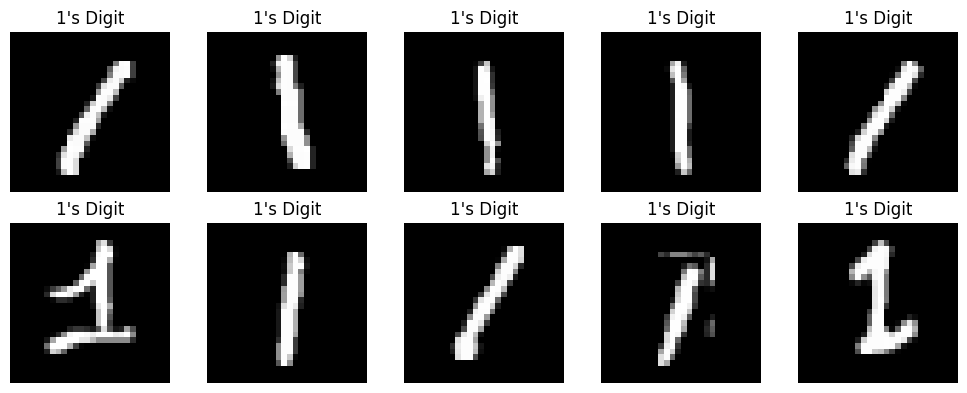

In [23]:
## Get MNIST dataset
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Get 1's digits  
digit_ones = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
ones_indices = [i for i, (img, label) in enumerate(digit_ones) if label == 1]
ones_images = [digit_ones[i][0] for i in ones_indices]
ones_images = torch.stack(ones_images)      

# Show the first 10 images of 1's
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(ones_images[i].view(28, 28).numpy(), cmap='gray')
    plt.axis('off')
    plt.title("1's Digit")
plt.tight_layout()
plt.show()

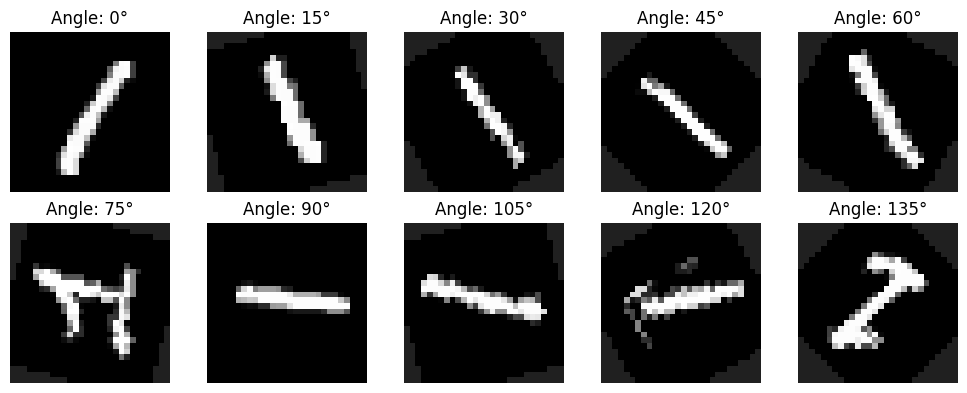

In [24]:
## Rotaded images of 1's digits

def rotate_images(images, angles):
    """
    Rotates a batch of images by specified angles.
    
    Parameters:
        images: tensor of shape [N, C, H, W]
        angles: list of angles in degrees for each image
    
    Returns:
        rotated_images: tensor of rotated images
    """
    rotated_images = []
    for img, angle in zip(images, angles):
        img_rotated = torchvision.transforms.functional.rotate(img, angle)
        rotated_images.append(img_rotated)
    return torch.stack(rotated_images)

# Define angles for rotation
angles = [0, 15, 30, 45, 60, 75, 90, 105, 120, 135]
rotated_images = rotate_images(ones_images[:10], angles)        

# Show the rotated images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(rotated_images[i].view(28, 28).numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f"Angle: {angles[i]}°")
plt.tight_layout()
plt.show()  

In [25]:
## LeNet with Dropout
class LeNetDropout(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(LeNetDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 16 * 4 * 4)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc3(x)
        return x    
    
# Instantiate the model
model_lenet = LeNetDropout(dropout_prob=0.5)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=0.001)    

mnist_train = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=mnist_transform)            

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)
# Training the model
n_epochs = 5
for epoch in range(n_epochs):       
    model_lenet.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_lenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {running_loss / len(train_loader):.4f}")


model_lenet.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model_lenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()   
print(f"Accuracy of the model on the test set: {100 * correct / total:.2f}%")   

Epoch [1/5], Loss: 0.4433
Epoch [2/5], Loss: 0.1428
Epoch [3/5], Loss: 0.1057
Epoch [4/5], Loss: 0.0903
Epoch [5/5], Loss: 0.0773
Accuracy of the model on the test set: 98.62%


In [26]:
## MC Dropout with LeNet

def get_mc_logits_and_probs(model, images, T=100):
    """
    Applies MC Dropout on a batch of rotated images.

    Args:
        model: trained model with dropout layers
        images: tensor of shape [N, 1, 28, 28] (rotated images)
        T: number of stochastic forward passes

    Returns:
        logits_list: list of Tensors of logits [T x N x 10]
        probs_list: list of Tensors of softmax outputs [T x N x 10]
    """
    model.train()  # Keep dropout active
    logits_T = []
    probs_T = []

    for _ in range(T):
        with torch.no_grad():
            output = model(images)             # [N, 10]
            logits_T.append(output)
            probs_T.append(F.softmax(output, dim=1))
    
    logits = torch.stack(logits_T)  # [T, N, 10]
    probs = torch.stack(probs_T)    # [T, N, 10]
    return logits, probs


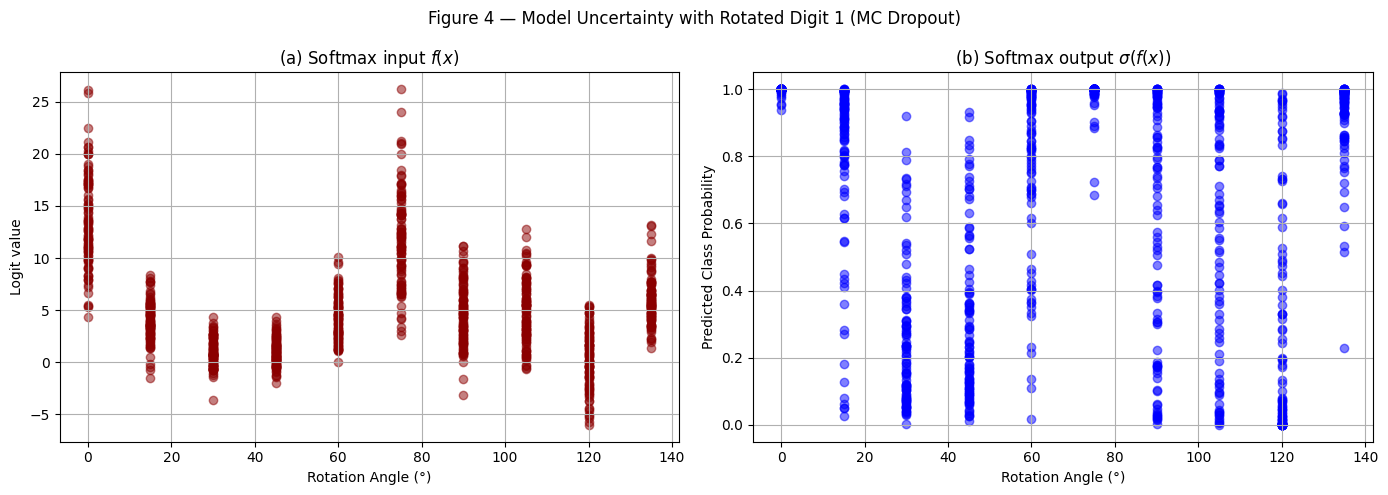

In [ ]:
T = 100
model_lenet.train()

# T predictions with activated dropout
logits_mc = []
probs_mc = []

with torch.no_grad():
    for _ in range(T):
        output = model_lenet(rotated_images)              
        logits_mc.append(output)
        probs_mc.append(F.softmax(output, dim=1))         

logits_mc = torch.stack(logits_mc)  
probs_mc = torch.stack(probs_mc)    

# Most probable class with the average of the probabilities
mean_probs = probs_mc.mean(dim=0)  # [N, 10]
top_classes = mean_probs.argmax(dim=1)  # [N]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# (a) Logits f(x)
for i in range(len(angles)):
    axs[0].scatter([angles[i]] * T, logits_mc[:, i, top_classes[i]].numpy(), alpha=0.5, color='darkred')
axs[0].set_title("(a) Softmax input $f(x)$")
axs[0].set_xlabel("Rotation Angle (°)")
axs[0].set_ylabel("Logit value")
axs[0].grid(True)

# (b) Softmax output
for i in range(len(angles)):
    axs[1].scatter([angles[i]] * T, probs_mc[:, i, top_classes[i]].numpy(), alpha=0.5, color='blue')
axs[1].set_title("(b) Softmax output $\\sigma(f(x))$")
axs[1].set_xlabel("Rotation Angle (°)")
axs[1].set_ylabel("Predicted Class Probability")
axs[1].grid(True)

plt.suptitle("Model Uncertainty with Rotated Digit 1 (MC Dropout)")
plt.tight_layout()
plt.show()

## VI. Comparison with Standard Dropout

In this section, I compare standard dropout inference with Monte Carlo (MC) Dropout to highlight how predictive uncertainty is only when dropout is active at test time.

Using the same trained LeNet model, I evaluate rotated versions of the digit "1" in two modes:
- **Standard Dropout**: the model is in `eval()` mode and dropout is disabled. Only one forward pass is used.
- **MC Dropout**: the model is kept in `train()` mode and 100 stochastic forward passes are averaged.

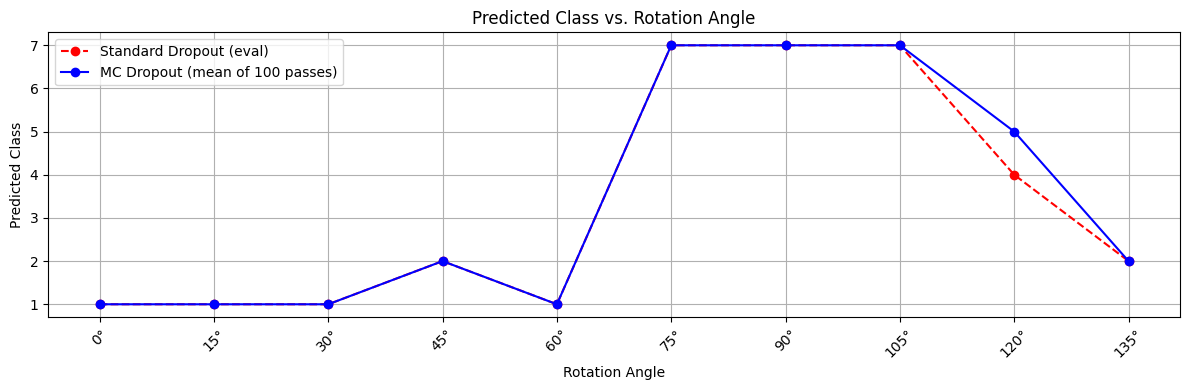

In [28]:
# Eval mode (Dropout off)
model_lenet.eval()
with torch.no_grad():
    preds_eval = F.softmax(model_lenet(rotated_images), dim=1)  # [N, 10]
    top_eval = preds_eval.argmax(dim=1)  # predicted classes

# MC Dropout mode (Dropout on)
model_lenet.train()
T = 100
mc_preds = []

with torch.no_grad():
    for _ in range(T):
        mc_preds.append(F.softmax(model_lenet(rotated_images), dim=1))  # [N, 10]

mc_preds = torch.stack(mc_preds)  # [T, N, 10]
mean_probs = mc_preds.mean(dim=0)  # [N, 10]
top_mc = mean_probs.argmax(dim=1)  # predicted classes (averaged)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(top_eval.numpy(), 'r--o', label="Standard Dropout (eval)")
plt.plot(top_mc.numpy(), 'b-o', label="MC Dropout (mean of 100 passes)")
plt.xticks(range(len(angles)), [f"{a}°" for a in angles], rotation=45)
plt.ylabel("Predicted Class")
plt.xlabel("Rotation Angle")
plt.title("Predicted Class vs. Rotation Angle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()